In [2]:
!pip install yfinance --quiet

zsh:1: command not found: pip


In [3]:
#패키지 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.optimize import minimize
sns.set()

##올웨더 포트폴리오 구성

Link: https://yaneodoo2.tistory.com/entry/%EC%98%AC%EC%9B%A8%EB%8D%94-%ED%8F%AC%ED%8A%B8%ED%8F%B4%EB%A6%AC%EC%98%A4%EC%9D%98-%EB%AA%A8%EB%93%A0-%EA%B2%83-%EB%B0%B1%ED%85%8C%EC%8A%A4%ED%8A%B8-%ED%8F%89%EA%B7%A0%EC%88%98%EC%9D%B5%EB%A5%A0-%EB%A0%88%EC%9D%B4%EB%8B%AC%EB%A6%AC%EC%98%A4

1. 40% 장기 채권: TLT
2. 15% 중기 채권: IEF
3. 30% 주식 시장: VTI
4. 7.5% 원자재: DBC
5. 7.5% 금,구리: GLD

In [4]:
import yfinance as yf

In [5]:
tickers = ['TLT','IEF','VTI','DBC','GLD',]

etf = yf.Tickers(tickers)
data = etf.history(start='2010-01-01', actions=False)
data.drop(['Open', 'High', 'Low', 'Volume'], inplace=True, axis=1)
data = data.droplevel(0, axis=1).resample('M').last()

[*********************100%***********************]  5 of 5 completed


In [6]:
#수익률 계산
rets = data.pct_change().fillna(0)
rets

,DBC,GLD,IEF,TLT,VTI
Date,,,,,
2010-01-31 00:00:00-05:00,0.000000,0.000000,0.000000,0.000000,0.000000
2010-02-28 00:00:00-05:00,0.041428,0.032748,0.003318,-0.003424,0.034400
2010-03-31 00:00:00-04:00,-0.004655,-0.004386,-0.010569,-0.020573,0.063958
2010-04-30 00:00:00-04:00,0.039116,0.058834,0.016527,0.033218,0.021816
2010-05-31 00:00:00-04:00,-0.101473,0.030513,0.029333,0.051083,-0.078831
...,...,...,...,...,...
2022-09-30 00:00:00-04:00,-0.070373,-0.028882,-0.047350,-0.082351,-0.092305
2022-10-31 00:00:00-04:00,0.050607,-0.017844,-0.014540,-0.059644,0.081128
2022-11-30 00:00:00-05:00,0.014729,0.084919,0.036123,0.071511,0.051693


##가중치 계산

'자산'별로 정해진 가중치가 있기 때문에 그거에 맞게 가중치를 부여해준다.


1. 40% 장기 채권: TLT
2. 15% 중기 채권: IEF
3. 30% 주식 시장: VTI
4. 7.5% 원자재: DBC
5. 7.5% 금,구리: GLD

In [7]:
#자산별 가중치 함수
def get_awp_weights(rets):
  #올웨더 포트폴리오 가중치 그대로 가져온것!
  weights = np.array([0.4,0.15,0.3,0.075,0.075])
  time_series_weights = np.ones_like(rets) * weights
  return time_series_weights

## MDD 계산

In [14]:
#MDD 계산 함수
def get_mdd(x):
    """
    MDD(Maximum Draw-Down)
    :return: (peak_upper, peak_lower, mdd rate)
    """
    arr_v = np.array(x)
    peak_lower = np.argmax(np.maximum.accumulate(arr_v) - arr_v)
    peak_upper = np.argmax(arr_v[:peak_lower])
    return peak_upper, peak_lower, (arr_v[peak_lower] - arr_v[peak_upper]) / arr_v[peak_upper]

get_mdd

<function __main__.get_mdd(x)>

### 동일 비중 파이차트 시각화

In [9]:
weights = get_awp_weights(rets)[-1]

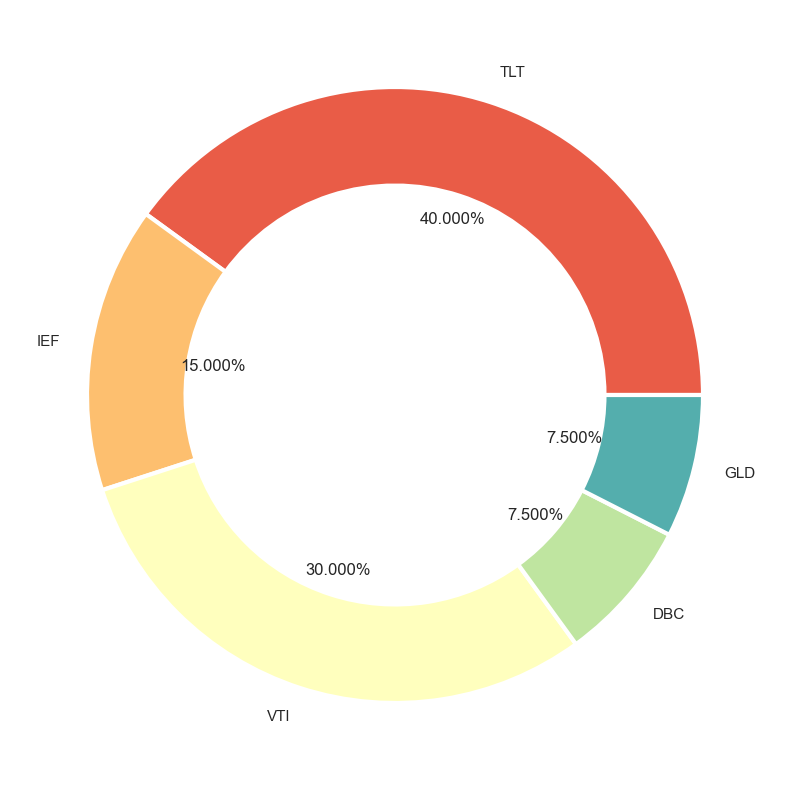

In [10]:
#색깔 팔레트
pal = sns.color_palette('Spectral',len(tickers))

# 파이차트 시각화
plt.figure(figsize=(10, 10))
wedgeprops = {'width': 0.32, 'edgecolor': 'w', 'linewidth': 3}
plt.pie(weights, labels=tickers, autopct='%.3f%%', wedgeprops=wedgeprops, colors=pal)
plt.show()

### 동일 비중 시계열 플랏 생성

Text(0, 0.5, 'Weights')

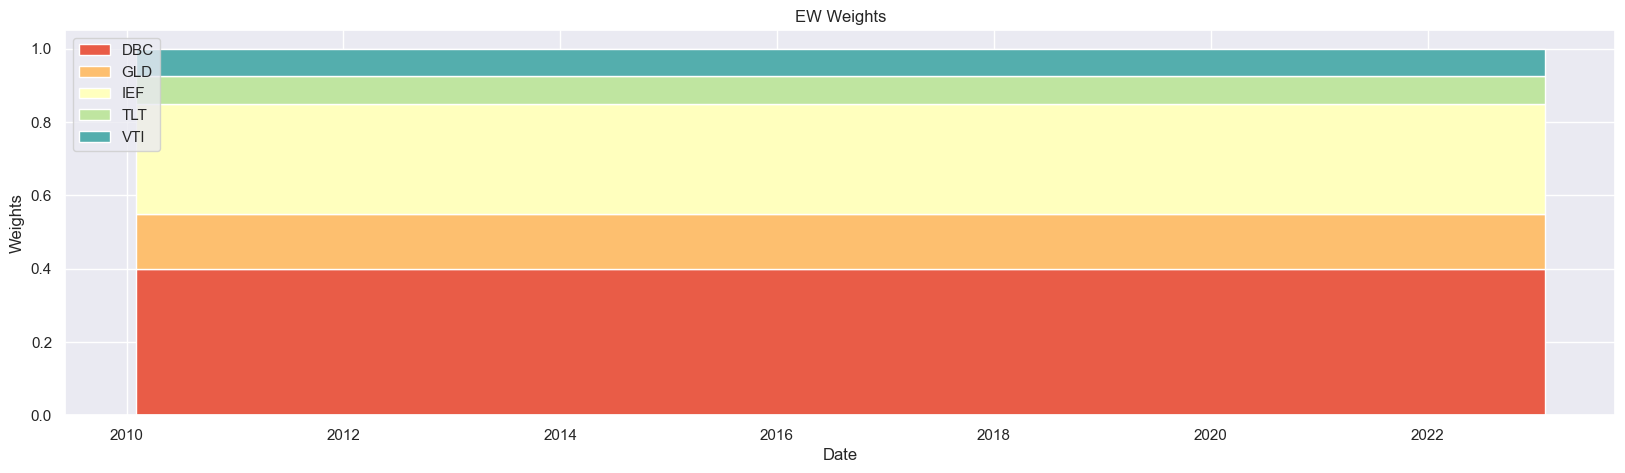

In [11]:
# 시계열 가중치 데이터프레임
awp_w_df = pd.DataFrame(get_awp_weights(rets), index=rets.index, columns=rets.columns)

# 그래프 결과
plt.figure(figsize=(20, 5))
plt.stackplot(awp_w_df.index, awp_w_df.T, labels=awp_w_df.columns, colors=pal)
plt.legend(loc='upper left')
plt.title('EW Weights')
plt.xlabel('Date')
plt.ylabel('Weights')

### 올웨더 포트폴리오 백테스팅 결과

In [12]:
# 포트폴리오 수익률
port_rets = awp_w_df.shift() * rets
port_rets.dropna(axis=0,how='any',inplace=True)

# 포트폴리오 누적 수익률
port_cum_rets = (1 + port_rets.sum(axis=1)).cumprod() - 1

'''
MDD 계산! => 최대 수익률 점과 최소 수익률 점을 찾아서 return값으로 반환시킨다
이때 주의할 점은 최대 수익률 점이 최소 수익률 점보다 왼쪽 편에 있어야된다!
'''

총 수익률: 60.8%
최대 수익률 낙폭: 37.85% -> 0.06%
MDD: -99.84%


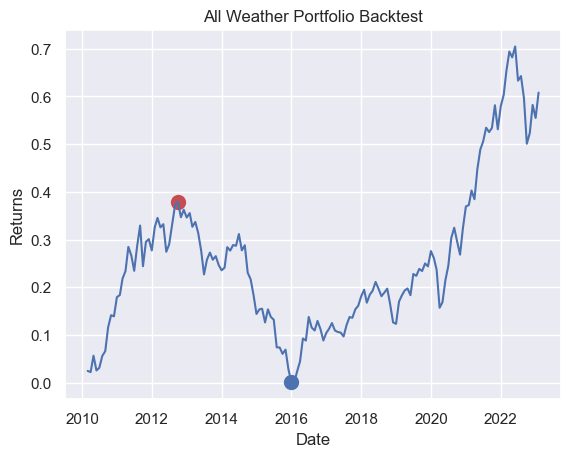

In [15]:
# 그래프 결과
plt.plot(port_cum_rets)
plt.title('All Weather Portfolio Backtest')
plt.xlabel('Date')
plt.ylabel('Returns')

# MDD 표시
upper = port_cum_rets.index[get_mdd(port_cum_rets)[0]]
lower = port_cum_rets.index[get_mdd(port_cum_rets)[1]]
plt.scatter(upper, port_cum_rets[upper], s = 100, c = 'r')
plt.scatter(lower, port_cum_rets[lower], s = 100, c = 'b')

print('총 수익률: ' + str(round(port_cum_rets[-1] * 100, 2)) + '%')
print('최대 수익률 낙폭: ' + '\033[95m' + str(round(port_cum_rets[upper] * 100, 2)) + '%' + ' -> ' + '\033[96m' + str(round(port_cum_rets[lower] * 100, 2)) + '%')
print('MDD: ' + str(round(get_mdd(port_cum_rets)[2] * 100, 2)) + '%')